In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [3]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

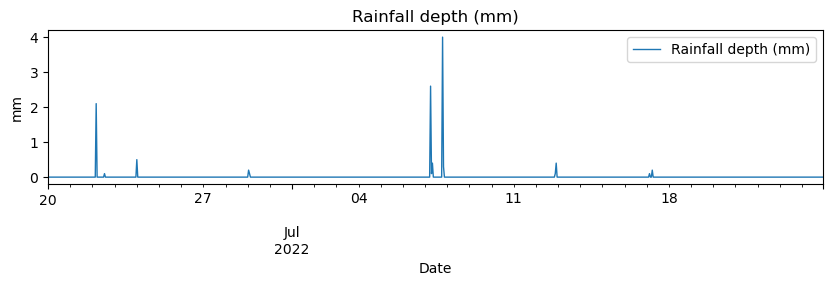

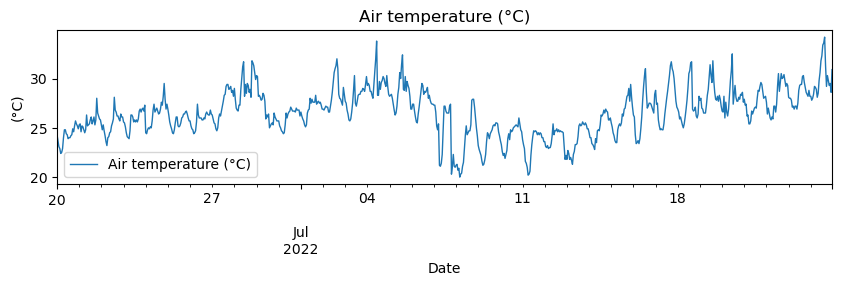

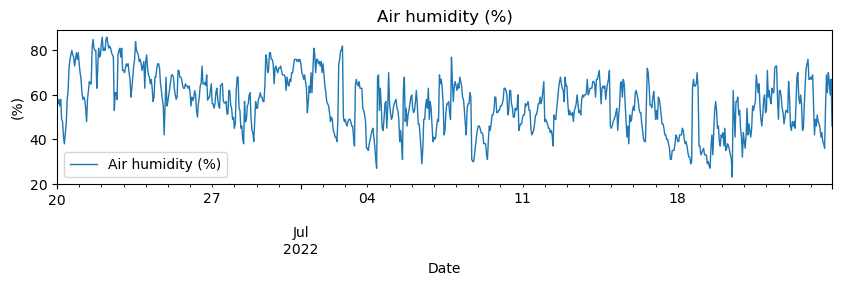

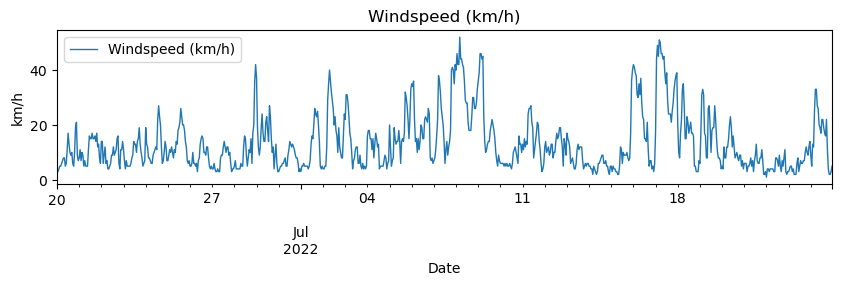

In [4]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-06-20'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98562D+00    |proj g|=  1.33011D-01


 This problem is unconstrained.



At iterate    5    f=  1.93495D+00    |proj g|=  2.47450D-01

At iterate   10    f=  1.90267D+00    |proj g|=  3.59559D-02

At iterate   15    f=  1.89749D+00    |proj g|=  2.58037D-02

At iterate   20    f=  1.89704D+00    |proj g|=  9.00174D-03

At iterate   25    f=  1.89610D+00    |proj g|=  1.80021D-02

At iterate   30    f=  1.89587D+00    |proj g|=  9.35551D-03

At iterate   35    f=  1.89511D+00    |proj g|=  3.95610D-02

At iterate   40    f=  1.89373D+00    |proj g|=  3.37137D-02

At iterate   45    f=  1.89318D+00    |proj g|=  2.90541D-02

At iterate   50    f=  1.89256D+00    |proj g|=  8.34367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

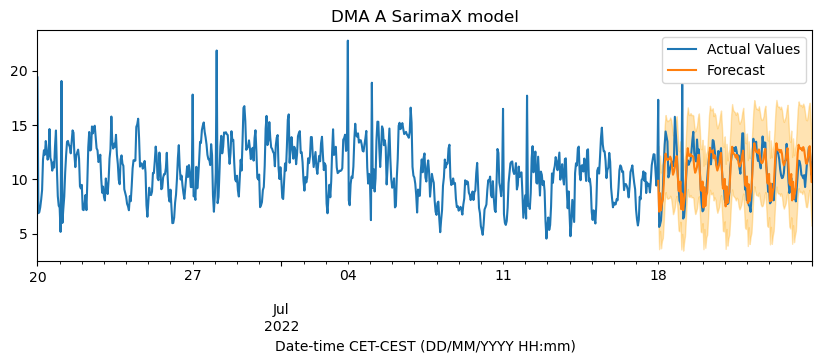

Performance indicators
DMA A Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.61            7.45             0.96           10.02 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.40            6.55             1.72           10.67 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06339D+00    |proj g|=  4.63254D-01


 This problem is unconstrained.



At iterate    5    f=  1.03170D+00    |proj g|=  9.89861D-02

At iterate   10    f=  9.95775D-01    |proj g|=  5.39622D-01

At iterate   15    f=  9.80606D-01    |proj g|=  1.43806D-01

At iterate   20    f=  9.79686D-01    |proj g|=  9.77963D-02

At iterate   25    f=  9.77293D-01    |proj g|=  3.04934D-02

At iterate   30    f=  9.76719D-01    |proj g|=  1.39020D-02

At iterate   35    f=  9.76250D-01    |proj g|=  2.74498D-02

At iterate   40    f=  9.75992D-01    |proj g|=  2.80159D-02

At iterate   45    f=  9.75912D-01    |proj g|=  1.59826D-02

At iterate   50    f=  9.75896D-01    |proj g|=  5.16343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

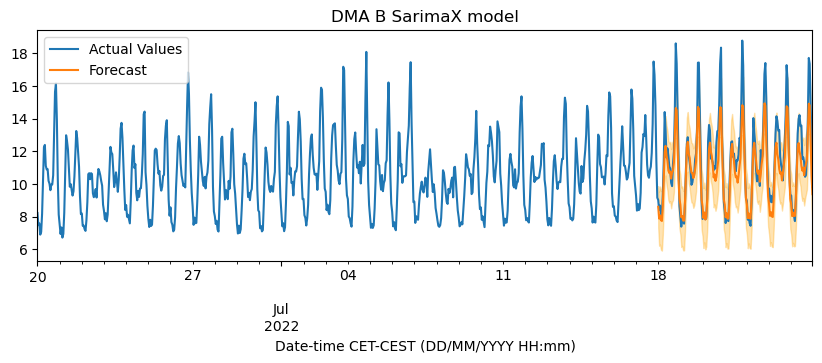

Performance indicators
DMA B Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.00            3.95             0.87           5.82 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.22            8.16             2.25           12.64 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34701D+00    |proj g|=  1.37560D+00


 This problem is unconstrained.



At iterate    5    f=  9.84982D-01    |proj g|=  4.93526D-01

At iterate   10    f=  8.22438D-01    |proj g|=  3.60724D-01

At iterate   15    f=  8.01874D-01    |proj g|=  2.48252D-01

At iterate   20    f=  7.93954D-01    |proj g|=  2.68015D-01

At iterate   25    f=  7.88694D-01    |proj g|=  4.01740D-01

At iterate   30    f=  7.85742D-01    |proj g|=  7.12139D-02

At iterate   35    f=  7.84633D-01    |proj g|=  2.47407D-02

At iterate   40    f=  7.84271D-01    |proj g|=  3.14040D-02

At iterate   45    f=  7.83476D-01    |proj g|=  8.24857D-03

At iterate   50    f=  7.83412D-01    |proj g|=  9.44123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

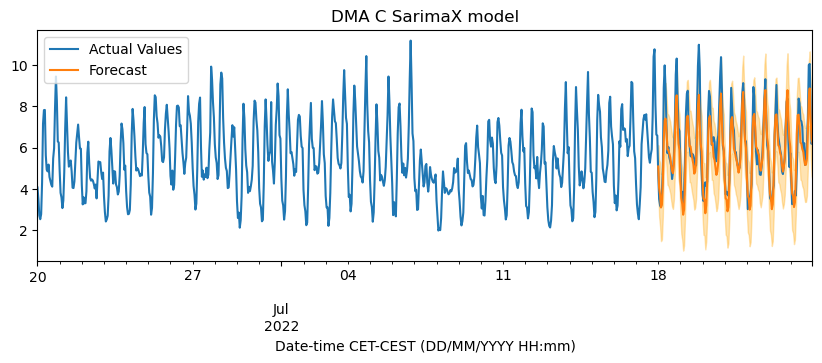

Performance indicators
DMA C Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.74            2.66             0.58           3.98 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.75            4.92             1.52           8.20 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43808D+00    |proj g|=  1.04888D-01


 This problem is unconstrained.



At iterate    5    f=  2.37585D+00    |proj g|=  2.75759D-01

At iterate   10    f=  2.34777D+00    |proj g|=  3.13477D-02

At iterate   15    f=  2.33828D+00    |proj g|=  9.57203D-03

At iterate   20    f=  2.33727D+00    |proj g|=  3.22898D-03

At iterate   25    f=  2.33725D+00    |proj g|=  1.23146D-03

At iterate   30    f=  2.33720D+00    |proj g|=  2.56456D-03

At iterate   35    f=  2.33719D+00    |proj g|=  1.57317D-04

At iterate   40    f=  2.33719D+00    |proj g|=  1.05141D-03

At iterate   45    f=  2.33716D+00    |proj g|=  2.41247D-03

At iterate   50    f=  2.33715D+00    |proj g|=  1.55634D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

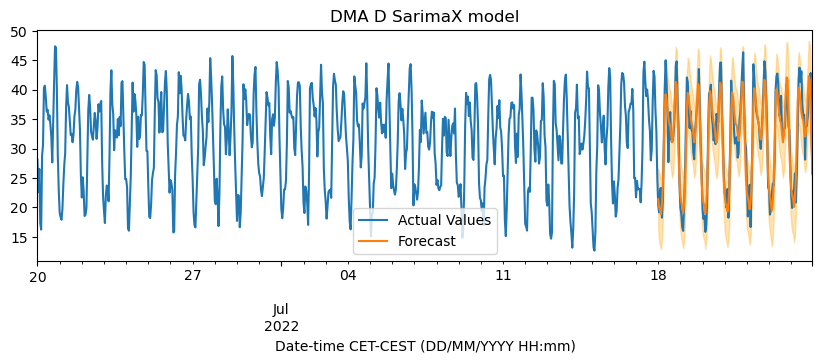

Performance indicators
DMA D Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.31            7.46             2.25           12.02 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.79            13.65             6.69           27.12 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24694D+00    |proj g|=  1.74044D-01


 This problem is unconstrained.



At iterate    5    f=  2.18699D+00    |proj g|=  1.45371D-01

At iterate   10    f=  2.16673D+00    |proj g|=  3.87340D-03

At iterate   15    f=  2.16661D+00    |proj g|=  4.23448D-03

At iterate   20    f=  2.16645D+00    |proj g|=  7.23789D-03

At iterate   25    f=  2.16641D+00    |proj g|=  7.06503D-04

At iterate   30    f=  2.16641D+00    |proj g|=  1.62177D-04

At iterate   35    f=  2.16641D+00    |proj g|=  3.21085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     38     45      1     0     0   4.435D-05   2.166D+00
  F =   2.1664079297294272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

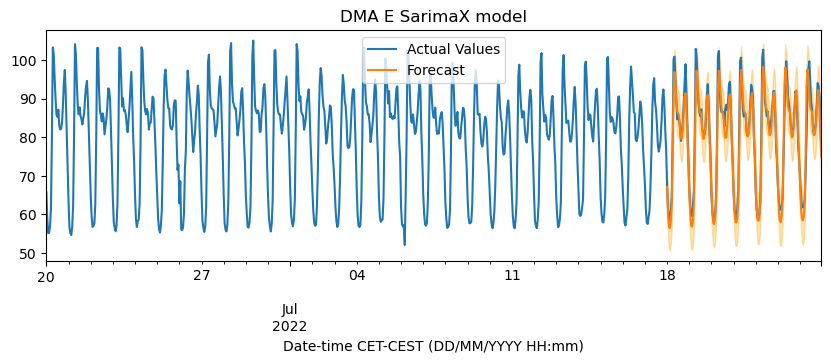

Performance indicators
DMA E Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.35            7.96             2.26           12.58 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
10.85            21.31             10.55           42.71 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60880D+00    |proj g|=  2.27791D-01


 This problem is unconstrained.



At iterate    5    f=  1.55790D+00    |proj g|=  7.64104D-02

At iterate   10    f=  1.53767D+00    |proj g|=  8.98697D-02

At iterate   15    f=  1.52550D+00    |proj g|=  4.06997D-02

At iterate   20    f=  1.52417D+00    |proj g|=  4.35096D-03

At iterate   25    f=  1.52411D+00    |proj g|=  5.00748D-03

At iterate   30    f=  1.52405D+00    |proj g|=  3.69782D-02

At iterate   35    f=  1.52399D+00    |proj g|=  2.04534D-03

At iterate   40    f=  1.52397D+00    |proj g|=  7.83488D-03

At iterate   45    f=  1.52390D+00    |proj g|=  4.92216D-03

At iterate   50    f=  1.52386D+00    |proj g|=  1.27113D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

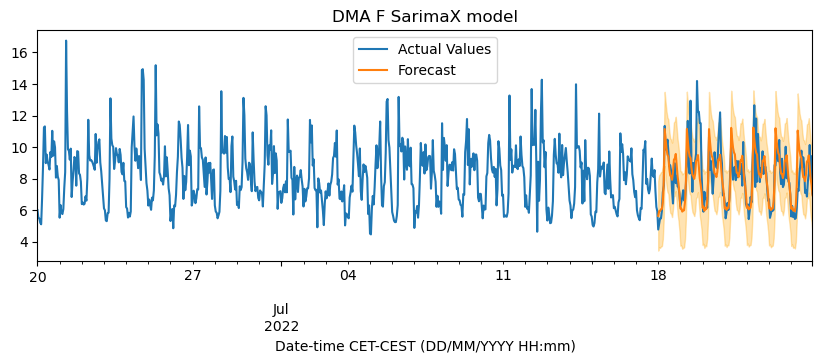

Performance indicators
DMA F Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.59            2.00             0.95           3.54 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.45            3.46             1.37           6.29 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70634D+00    |proj g|=  1.57841D-01


 This problem is unconstrained.



At iterate    5    f=  1.66531D+00    |proj g|=  1.69767D-01

At iterate   10    f=  1.63333D+00    |proj g|=  2.73957D-02

At iterate   15    f=  1.63239D+00    |proj g|=  8.75919D-03

At iterate   20    f=  1.63151D+00    |proj g|=  2.36683D-02

At iterate   25    f=  1.63131D+00    |proj g|=  1.80691D-02

At iterate   30    f=  1.63094D+00    |proj g|=  5.81409D-03

At iterate   35    f=  1.63090D+00    |proj g|=  2.37113D-03

At iterate   40    f=  1.63089D+00    |proj g|=  2.09410D-03

At iterate   45    f=  1.63082D+00    |proj g|=  3.41673D-02

At iterate   50    f=  1.63063D+00    |proj g|=  9.77537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

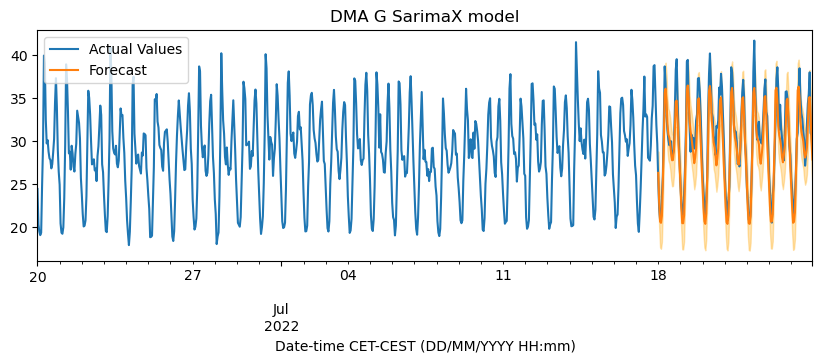

Performance indicators
DMA G Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.36            4.82             1.62           7.80 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.27            11.09             4.59           19.95 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61438D+00    |proj g|=  1.10516D-01


 This problem is unconstrained.



At iterate    5    f=  1.57557D+00    |proj g|=  5.04403D-01

At iterate   10    f=  1.53526D+00    |proj g|=  1.36373D-01

At iterate   15    f=  1.53347D+00    |proj g|=  2.48776D-03

At iterate   20    f=  1.53345D+00    |proj g|=  8.88677D-04

At iterate   25    f=  1.53343D+00    |proj g|=  1.14797D-03

At iterate   30    f=  1.53343D+00    |proj g|=  2.02928D-04

At iterate   35    f=  1.53343D+00    |proj g|=  1.66295D-03

At iterate   40    f=  1.53342D+00    |proj g|=  6.50517D-03

At iterate   45    f=  1.53341D+00    |proj g|=  4.37210D-03

At iterate   50    f=  1.53337D+00    |proj g|=  2.85435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

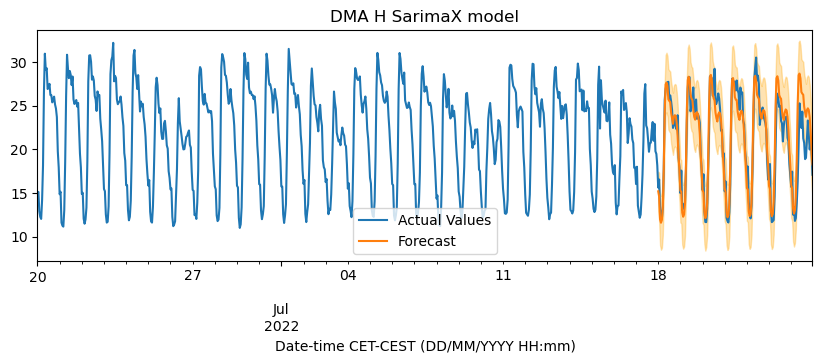

Performance indicators
DMA H Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.79            2.35             1.53           4.67 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.49            9.41             4.49           18.39 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88426D+00    |proj g|=  1.57929D-01


 This problem is unconstrained.



At iterate    5    f=  1.79441D+00    |proj g|=  9.29422D-02

At iterate   10    f=  1.75520D+00    |proj g|=  8.56580D-02

At iterate   15    f=  1.75011D+00    |proj g|=  1.53841D-02

At iterate   20    f=  1.74838D+00    |proj g|=  1.92087D-03

At iterate   25    f=  1.74833D+00    |proj g|=  5.92513D-03

At iterate   30    f=  1.74823D+00    |proj g|=  7.96026D-03

At iterate   35    f=  1.74804D+00    |proj g|=  1.74029D-02

At iterate   40    f=  1.74797D+00    |proj g|=  1.10552D-02

At iterate   45    f=  1.74766D+00    |proj g|=  6.01168D-03

At iterate   50    f=  1.74741D+00    |proj g|=  7.20938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

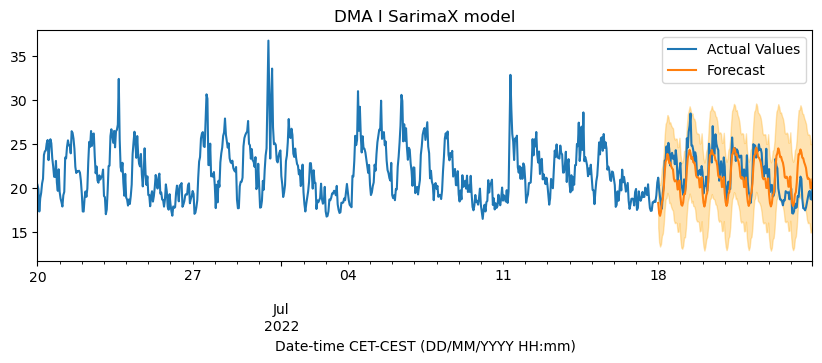

Performance indicators
DMA I Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.49            3.44             1.77           6.70 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.89            4.07             2.16           8.11 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69209D+00    |proj g|=  1.95002D+00


 This problem is unconstrained.



At iterate    5    f=  1.90675D+00    |proj g|=  2.57582D-01

At iterate   10    f=  1.77373D+00    |proj g|=  1.09739D-01

At iterate   15    f=  1.75087D+00    |proj g|=  1.86117D-02

At iterate   20    f=  1.74749D+00    |proj g|=  6.76752D-02

At iterate   25    f=  1.74612D+00    |proj g|=  8.33029D-03

At iterate   30    f=  1.74599D+00    |proj g|=  1.18893D-02

At iterate   35    f=  1.74598D+00    |proj g|=  1.32984D-03

At iterate   40    f=  1.74596D+00    |proj g|=  1.36370D-04

At iterate   45    f=  1.74596D+00    |proj g|=  6.86562D-05

At iterate   50    f=  1.74596D+00    |proj g|=  2.61920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

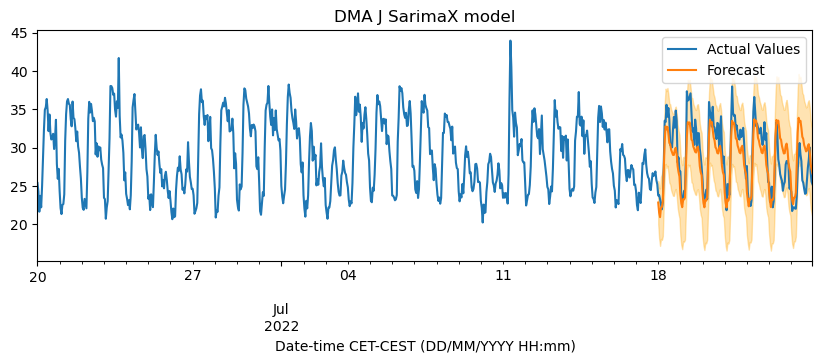

Performance indicators
DMA J Sarima 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.92            4.95             2.13           9.00 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.07            7.01             3.72           14.80 



In [5]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    model = SARIMAX(y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 4-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [6]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A Sarima 4-Weeks,1.615,7.449,0.958,10.022
DMA B Sarima 4-Weeks,0.995,3.954,0.871,5.819
DMA C Sarima 4-Weeks,0.739,2.662,0.584,3.984
DMA D Sarima 4-Weeks,2.307,7.460,2.255,12.021
DMA E Sarima 4-Weeks,2.355,7.961,2.262,12.578
DMA F Sarima 4-Weeks,0.592,2.003,0.950,3.544
DMA G Sarima 4-Weeks,1.362,4.822,1.615,7.799
DMA H Sarima 4-Weeks,0.786,2.354,1.530,4.670
DMA I Sarima 4-Weeks,1.487,3.444,1.765,6.697
DMA J Sarima 4-Weeks,1.916,4.953,2.134,9.003


In [7]:
print(f"{results_df['Total'].sum() :.2f}")

76.14


In [8]:
print(f"{results_df.drop('DMA E Sarima 4-Weeks')['Total'].sum() :.2f}")

63.56
